In [1]:
## Preparation

# Import the necessary libraries
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

## Global Var

dataset_path = os.getcwd() + '/dataset/classified'

class_labels = ["Normal", "Cataract"]

In [2]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)  # Check the CUDA version PyTorch is using
print(torch.cuda.current_device()) # Check CUDA device used

True
12.6
0


In [3]:
# Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load Dataset
ds = datasets.ImageFolder(root=dataset_path, transform=transform)

indices = list(range(len(ds)))
# labels = [ds.targets[i] for i in indices]

# Split into train and test dataset
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_ds = Subset(ds, train_indices)
test_ds = Subset(ds, test_indices)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

total_samples  = len(train_ds) + len(test_ds)

print(f"Train size: {(len(train_ds) / total_samples) * 100:.2f}%, Test size: {(len(test_ds)/total_samples)*100:.2f}%")
print(f"Total samples: {total_samples}, Train size: {len(train_ds)}, Test size: {len(test_ds)}")

Train size: 79.98%, Test size: 20.02%
Total samples: 1159, Train size: 927, Test size: 232


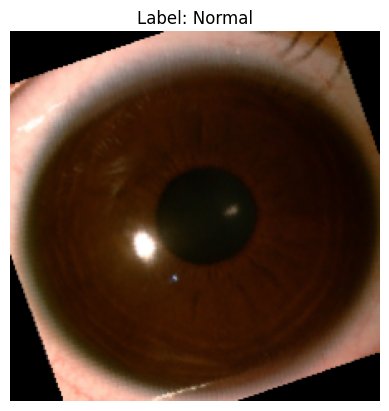

In [4]:
def denormalize(tensor, mean=None, std=None):
    if std is None:
        std = [0.5, 0.5, 0.5]
    if mean is None:
        mean = [0.5, 0.5, 0.5]
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean  # Reverse normalization

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select one image
img = images[0]
label = labels[0].item()

# Denormalize image
img = denormalize(img)

# Convert from Tensor (C, H, W) to NumPy (H, W, C)
img = np.transpose(img.numpy(), (1, 2, 0))

# Plot the image
plt.imshow(img)
plt.title(f"Label: {class_labels[label]}")  # Display label
plt.axis("off")
plt.show()

In [ ]:
torch.backends.cudnn.benchmark = True

# Load model efficient net
model = models.efficientnet_b0(progress=True, weights=models.EfficientNet_B0_Weights.DEFAULT)

for param in model.features.parameters():
    param.requires_grad = False

number_of_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(number_of_features, 128), nn.ReLU(), nn.Linear(128, 1), nn.Sigmoid()
)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Train the model
device_name = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on device {device_name}")

# We will use cuda 
device = torch.device(device_name)
model.to(device)

num_epochs = 5 * 3
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # scheduler.step()

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


print("Finished Training.")

Training on device cuda
Epoch [1/15], Loss: 0.5749, Accuracy: 69.69%
Epoch [2/15], Loss: 0.4439, Accuracy: 79.18%


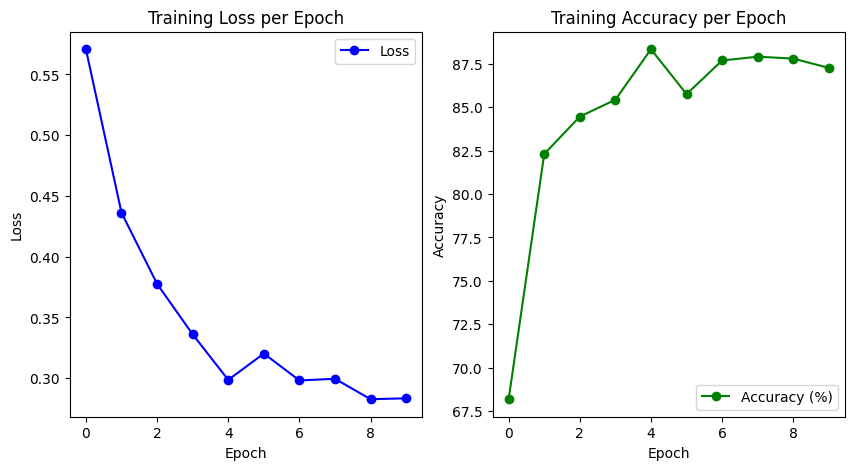

In [6]:
plt.figure(figsize=(10, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss", marker="o", linestyle="-", color="b")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Accuracy (%)", marker="o", linestyle="-", color="g")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()

plt.show()

In [7]:
# Evaluate Model
model.eval()
correct = 0
total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
        outputs = model(images)
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print Accuracy
test_acc = (correct / total) * 100
print(f"🎯 Model Accuracy: {test_acc:.2f}%")


🎯 Model Accuracy: 88.79%


Accuracy: 88.79%
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93       174
         1.0       0.83      0.69      0.75        58

    accuracy                           0.89       232
   macro avg       0.87      0.82      0.84       232
weighted avg       0.88      0.89      0.88       232



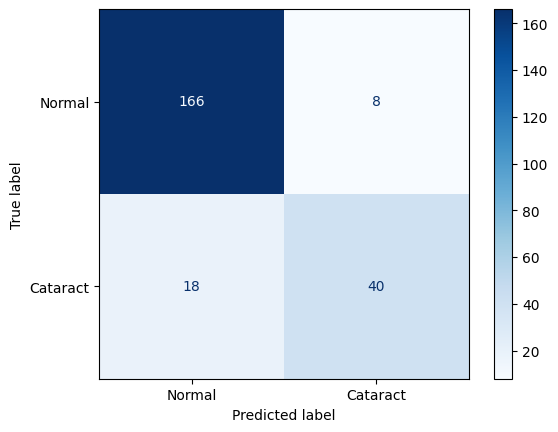

In [8]:
conf_matrix = confusion_matrix(np.array(all_labels), np.array(all_preds))
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap=plt.cm.Blues)

print(f"Accuracy: {test_acc:.2f}%")

cr = classification_report(np.array(all_labels), np.array(all_preds))
print(cr)

In [9]:
# # save
# output_model_path = f"output/checkpoint-{test_acc}-80x20-aug.pth"
# output_model_path = f"output/checkpoint-{test_acc}-70x30-aug.pth"
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict()
# }, output_model_path)

In [10]:
# checkpoint = torch.load("checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# model.eval()